In [1]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [2]:
import numpy as np
import pandas as pd
from joblib import dump, load
from collections import namedtuple
from IPython.display import display
from pprint import pprint
from circuit_presets import get_wire_combos
from IPython.core.display import display, HTML
from reporting_functions import (
    get_file_content,
    confusion_matrix_stats,
    get_result_table,
    get_result_table_target_pairs,
    gather_results_0_12,
    get_experiment_config,
    get_model_names,
    plot_loss,
    get_line_plot_data,
    plot_119_accuracy_per_structure,
    gather_results_118_135,
    gather_resultdf_1000,
    gather_result_list_1000,
    get_model_result_list,
    get_circuit_diagram,
    get_wire_combos_graph,
    gather_resultdf_991000
)
path_experiments = f"{project_home_dir}/experiments"

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

pd.set_option("display.max_rows", 100)

<ipython-input-2-1a1ccadafe91>:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Data: HTRU2 (High Time Resolution Universe Survey (South))
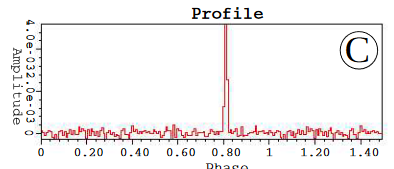
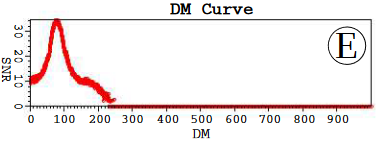
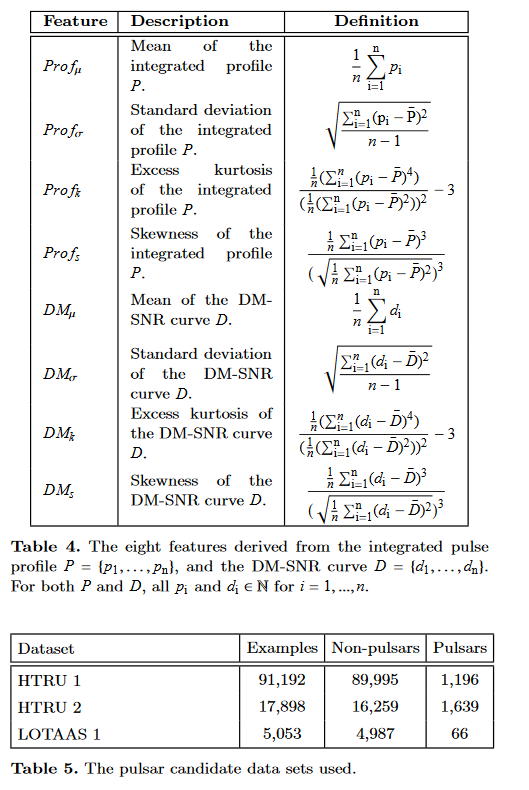

### Experiment hep-1000
___
HTRU2 data testing out different structural hyperparameters, oversampling done on training data
 - **Encoding**: Angle
 - **Circuit**: U_5
 - **Scaling**: MinMax(0,pi/2)
 - **Feature Selection**: PCA(8), Tree(8,50)
 - **Iterations**: 100
 - **batch_size**: 100
 - **Cross Validation**: 5 folds
 - **Structures**:{
                    "n_wires": [8],
                    "c_step": [1,3,5,7],
                    "pool_pattern": ["right","left","inside","outside","eo_even","eo_odd"],
                    "p_step": [0],
                    "wire_to_cut": [0]}
 **Papers:**
  - https://arxiv.org/abs/2112.02655: Quantum Machine Learning for Radio Astronomy - Mohammad Kordzanganeh, Aydin Utting, Anna Scaife.
  - https://arxiv.org/abs/1603.05166: Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach - R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles

In [3]:
from reporting_functions import (
    plot_triangle_accuracies,
    get_result_table_target_pairs,    
)

exp_id = 991000
result_list = gather_result_list_1000(exp_id, path_experiments=path_experiments)
result_data = gather_resultdf_991000(result_list)
print(f"Number of Models: {len(result_list)}")

Number of Models: 48


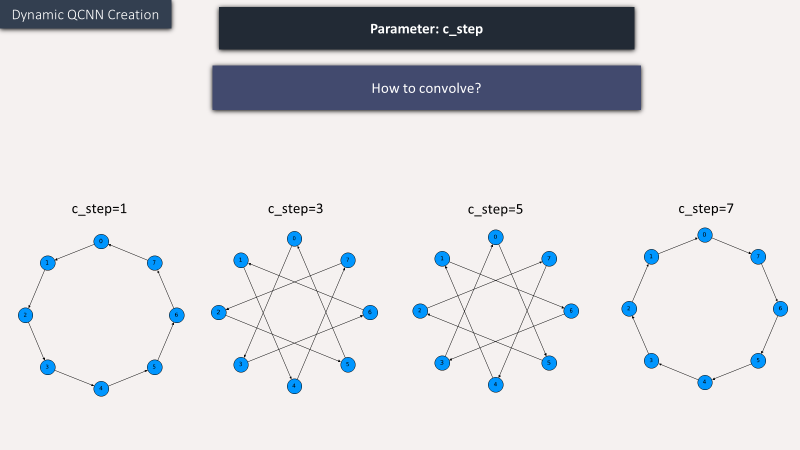
___
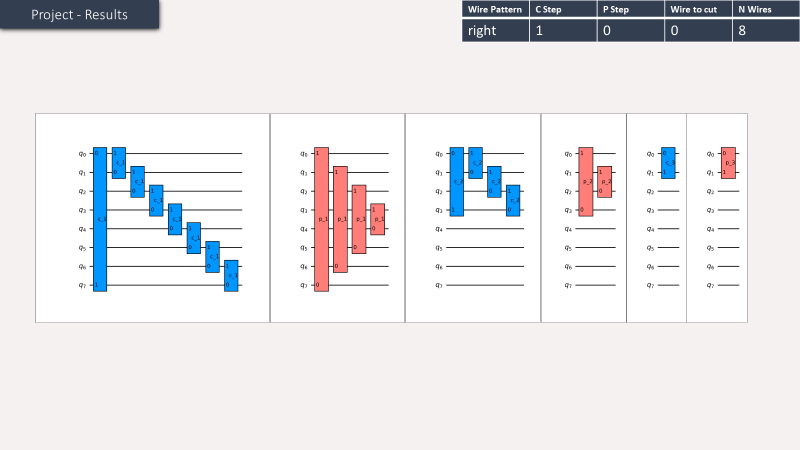
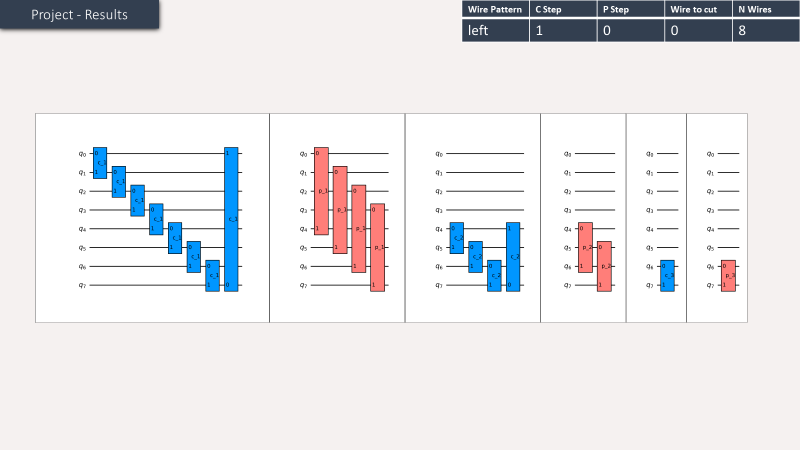
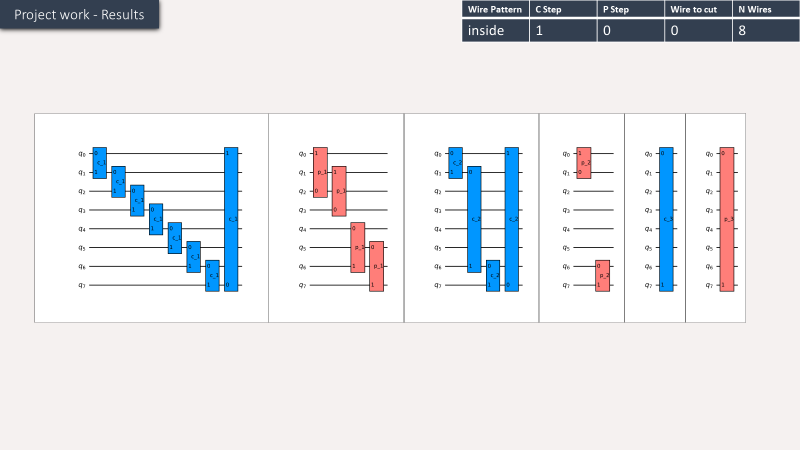
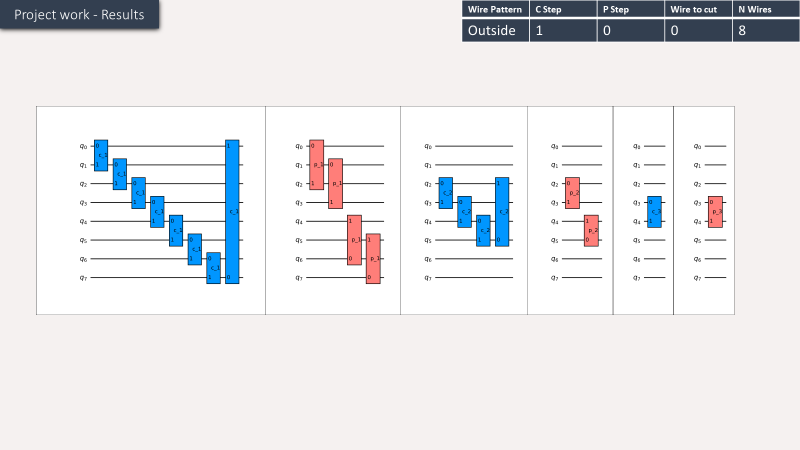
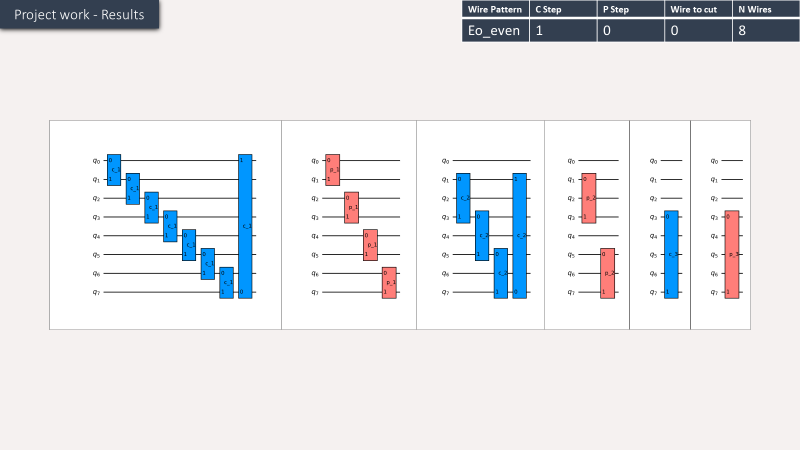
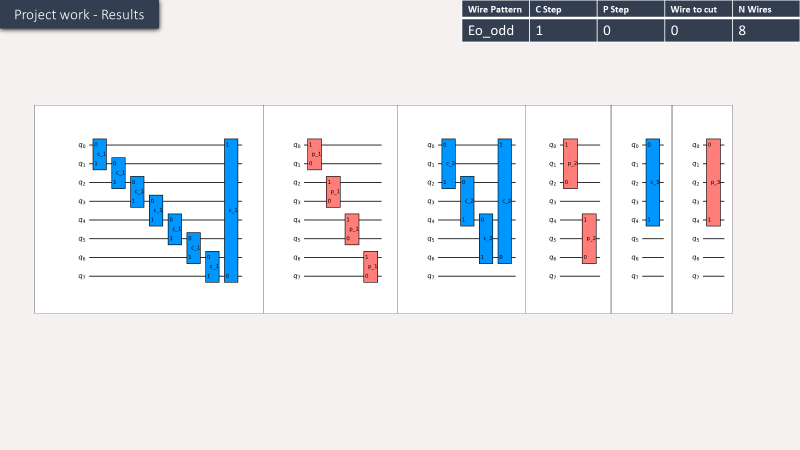

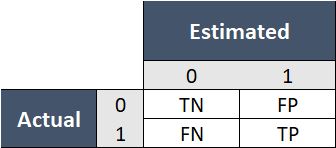

\begin{align}
TPR &= \frac{TP}{TP+FN}&\text{Correctly classified positives out of all actual positives}\\\\
FPR &= \frac{TN}{TN+FP}&\text{Correctly classified negatives out of all actual negatives}\\\\
Informedness &= TPR + FPR -1&
\end{align}


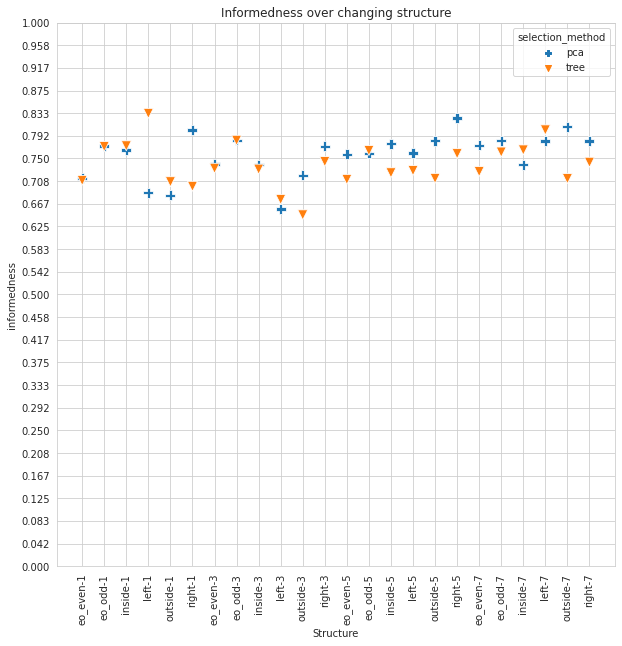

In [4]:
from reporting_functions import generic_plot_201

groupby = ["pool_pattern", "selection_method"]
metric = "informedness"
filter_col_val = lambda data, col, val: data.apply(
        lambda row: row[col] == val, axis=1
    )
plot_data = pd.DataFrame()
for k in range(1,9,2):
    filtered = result_data[
            filter_col_val(result_data, "c_step", k)
        ].copy()
    tmp_plot_data = get_line_plot_data(filtered, groupby, metric)
    tmp_plot_data[groupby[0]] = [f"{ind}-{k}" for ind in tmp_plot_data.index]
    tmp_plot_data.index = [f"{ind}-{k}" for ind in tmp_plot_data.index]
    
    plot_data = plot_data.append(tmp_plot_data)


plot = generic_plot_201(plot_data, x=groupby[0], y=metric, hue=groupby[1], title=f"{metric.title()} over changing structure", x_label="Structure" )

In [7]:
top_result.model_configuration.additional_structure

('U_5',
 'psatz1',
 {'c_step': 1,
  'n_wires': 8,
  'p_step': 0,
  'pool_pattern': 'left',
  'wire_to_cut': 0})

In [132]:
result_table = get_result_table(result_data,["selection_method","c_step","pool_pattern" ],"informedness")
# result_table


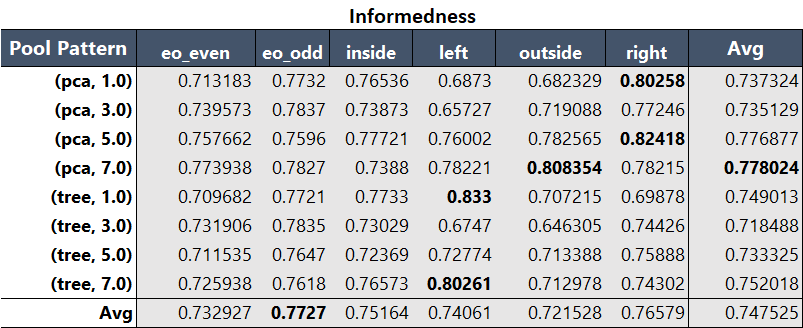

In [134]:
result_table = get_result_table(result_data,["selection_method","c_step","pool_pattern" ],"std_test_score")
# result_table


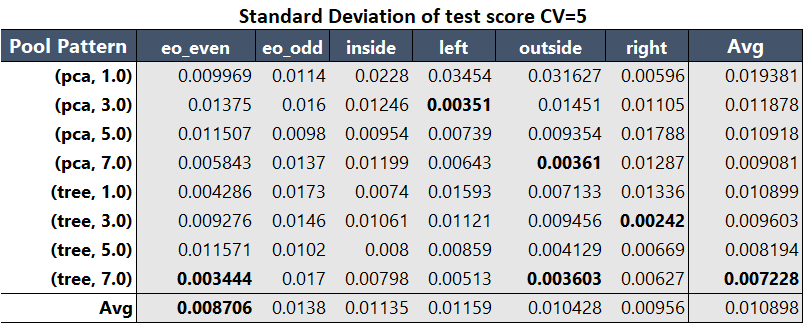

In [5]:
top_5 = ["tree-1-left","pca-5-right" ,"pca-7-outside", "tree-7-left", "pca-1-right"]
top_5_result_id = []
top_result = None
for result in result_list:
    config_id = f"{result.model_configuration.selection_method}-{result.model_configuration.additional_structure[2]['c_step']}-{result.model_configuration.additional_structure[2]['pool_pattern']}"
    if config_id in top_5:
        top_5_result_id.append(result.model_name)
        if result.model_name=="8be40d962267421e83f1c8640f618878":
            top_result = result
# result_table = get_result_table(result_data,["selection_method","c_step","pool_pattern" ],"informedness")
# result_table

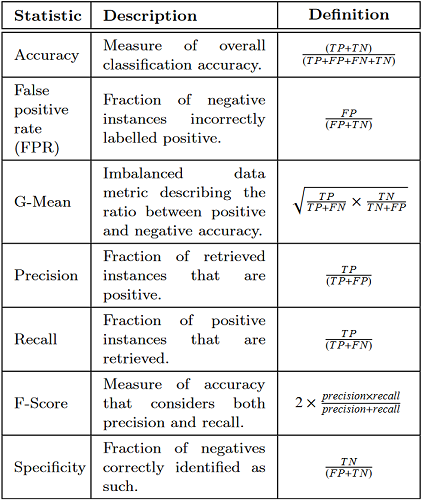
- https://arxiv.org/abs/1603.05166: Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach - R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles

In [19]:
filter_col_val = lambda data, col, val: data.apply(
        lambda row: row[col] in val, axis=1
    )
filtered = result_data[
            filter_col_val(result_data, "model_id", top_5_result_id)
        ].copy()
filtered.loc[:, ["model_id","selection_method", "pool_pattern","c_step","TPR","TNR","informedness","gmean", "accuracy","f1_score","fpr","precision" ]]

,model_id,selection_method,pool_pattern,c_step,TPR,TNR,informedness,gmean,accuracy,f1_score,fpr,precision
4,b5f6340cedd14109a7da5d50ed822026,pca,outside,7.0,0.833333,0.975020,0.808354,0.901397,0.962197,0.799605,0.024980,0.768501
18,fd65c20ca7db43e6a83d182d2826843b,pca,right,1.0,0.825103,0.977477,0.802580,0.898064,0.963687,0.804413,0.022523,0.784736
32,6bec4c1bcb874cf4863ab0da08f9c215,pca,right,5.0,0.845679,0.978501,0.824180,0.909669,0.966480,0.820359,0.021499,0.796512
37,5c9bb848ce324b7890b91583369bc517,tree,left,7.0,0.831276,0.971335,0.802611,0.898581,0.958659,0.784466,0.028665,0.742647
42,8be40d962267421e83f1c8640f618878,tree,left,1.0,0.890947,0.942056,0.833002,0.916145,0.937430,0.720466,0.057944,0.604749



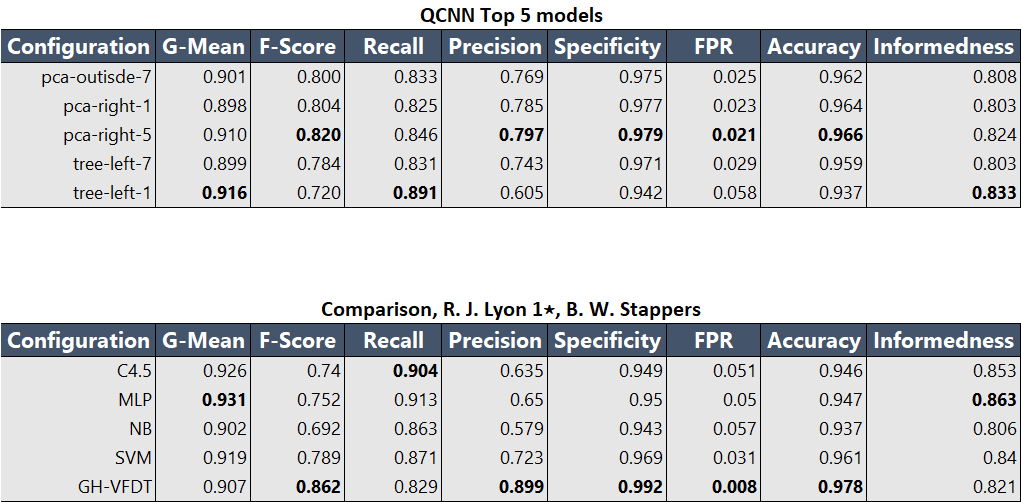


<br/>


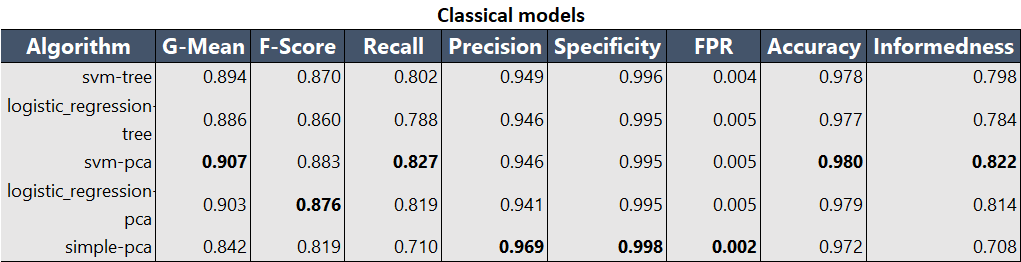

In [18]:
from reporting_functions import get_cf_matrix
result=result_list[0]
cf_matrix = get_cf_matrix(result.samples_tfd.y_test,result.y_test_hat)
TN, FP, FN, TP = cf_matrix[0, 0], cf_matrix[0, 1], cf_matrix[1, 0], cf_matrix[1, 1]
positives = TP+FN
negatives = TN + FP

print(f"Actual pulsars {positives}")
print(f"Actual non pulsars {negatives}")
print(f"Accuracy by predicing everything as not a pulsar: {negatives/(positives+negatives)}")

Actual pulsars 486
Actual non pulsars 4884
Accuracy by predicing everything as not a pulsar: 0.9094972067039107


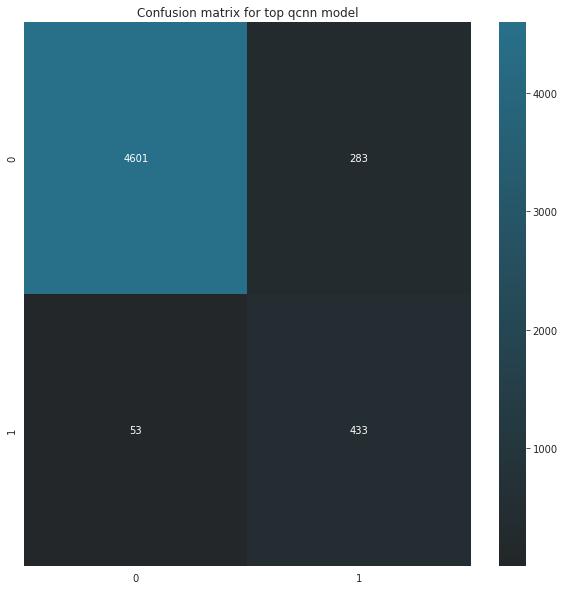

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
result = top_result

cf_matrix = get_cf_matrix(result.samples_tfd.y_test, result.y_test_hat)

figsize = (10,10)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title("Confusion matrix for top qcnn model")
    sns.heatmap(
        cf_matrix,
        annot=True,
        fmt="0",
        ax=ax,
        vmin=0.3,
        cmap=sns.dark_palette("#28708a", reverse=False, as_cmap=True),
       # mask=mask,
    )


In [28]:
print(f"{cf_matrix[0,0]} Correctly classified non pulsars as non pulsars")
print(f"{cf_matrix[0,1]} In-correctly classified non-pulsars as pulsars")
print(f"{cf_matrix[1,0]} In-correctly classified pulsars as non-pulsars")
print(f"{cf_matrix[1,1]} Correctly classified pulsars as pulsars")

4601 Correctly classified non pulsars as non pulsars
283 In-correctly classified non-pulsars as pulsars
53 In-correctly classified pulsars as non-pulsars
433 Correctly classified pulsars as pulsars


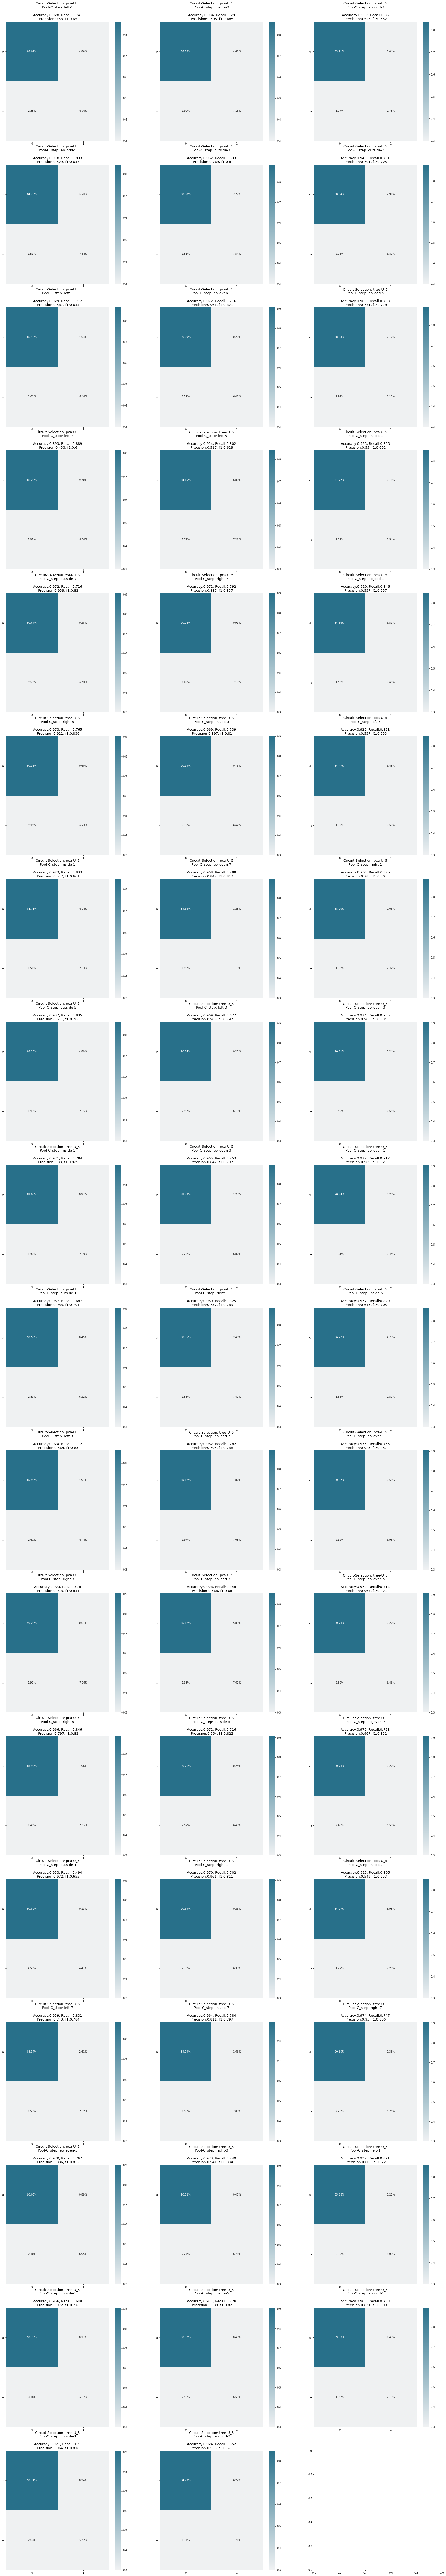

In [86]:
from reporting_functions import confusion_matrix_stats
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rc("axes", titlesize=13)  # fontsize of the axes title
figsize = (10,10) # 
n_col=3
n_plots = len(result_list)
n_rows = int(np.ceil(n_plots / n_col))
fig, ax = plt.subplots(n_rows, n_col, figsize=(figsize[0]*n_col, n_rows * figsize[1]))
for result, i in zip(result_list, range(n_plots)):
    col = i % n_col
    row = i // n_col
    cf_matrix = confusion_matrix(result.samples_tfd.y_test, result.y_test_hat)
    cf_matrix = cf_matrix/np.sum(cf_matrix)
    accuracy, precision, recall, f1_score, stats_text = confusion_matrix_stats(cf_matrix)       
    title_text = (
        f"Circuit-Selection: {result.model_configuration.selection_method}-{result.model_configuration.additional_structure[0]}\n"
        f"Pool-C_step: {result.model_configuration.additional_structure[2]['pool_pattern']}-{result.model_configuration.additional_structure[2]['c_step']}\n\n"
        f"Accuracy:{accuracy:.3f}, Recall:{recall:.3}\n Precision:{precision:.3}, f1:{f1_score:.3}"
    )
    ax[row,col].set_title(title_text)
    ax[row, col].set_xlabel(f"Predicted label\n\n")
    ax[row, col].set_xlabel(f"True label")
    with sns.axes_style("whitegrid", { 'axes.labelcolor': 'red'}):
        sns.heatmap(
            cf_matrix,
            annot=True,
            fmt="0.2%",
            ax=ax[row,col],
            vmin=0.3,
            cmap=sns.light_palette("#28708a", reverse=False, as_cmap=True),
        )

In [58]:
print(classification_report(result.samples_tfd.y_test, result.y_test_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4884
           1       0.95      0.79      0.86       486

    accuracy                           0.98      5370
   macro avg       0.96      0.89      0.92      5370
weighted avg       0.98      0.98      0.98      5370



In [59]:
result = result_list[3]
print(result.model_configuration.selection_method, result.model_configuration.algorithm)

pca svm


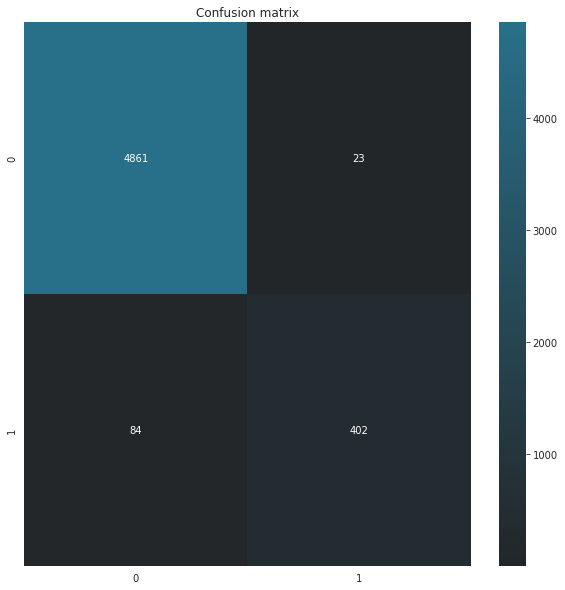

In [60]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
cf_matrix = confusion_matrix(result.samples_tfd.y_test, result.y_test_hat)

figsize = (10,10)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title("Confusion matrix")
    sns.heatmap(
        cf_matrix,
        annot=True,
        fmt="0",
        ax=ax,
        vmin=0.3,
        cmap=sns.dark_palette("#28708a", reverse=False, as_cmap=True),
       # mask=mask,
    )

In [61]:
print(classification_report(result.samples_tfd.y_test, result.y_test_hat))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4884
           1       0.95      0.83      0.88       486

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.94      5370
weighted avg       0.98      0.98      0.98      5370



In [62]:
result = result_list[4]
print(result.model_configuration.selection_method, result.model_configuration.algorithm)

pca logistic_regression


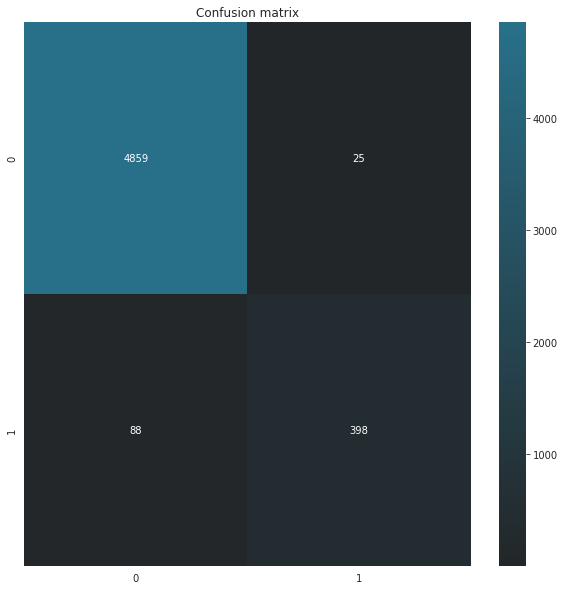

In [63]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
cf_matrix = confusion_matrix(result.samples_tfd.y_test, result.y_test_hat)

figsize = (10,10)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title("Confusion matrix")
    sns.heatmap(
        cf_matrix,
        annot=True,
        fmt="0",
        ax=ax,
        vmin=0.3,
        cmap=sns.dark_palette("#28708a", reverse=False, as_cmap=True),
       # mask=mask,
    )

In [64]:
print(classification_report(result.samples_tfd.y_test, result.y_test_hat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4884
           1       0.94      0.82      0.88       486

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370



In [65]:
result = result_list[5]
print(result.model_configuration.selection_method, result.model_configuration.algorithm)

pca simple


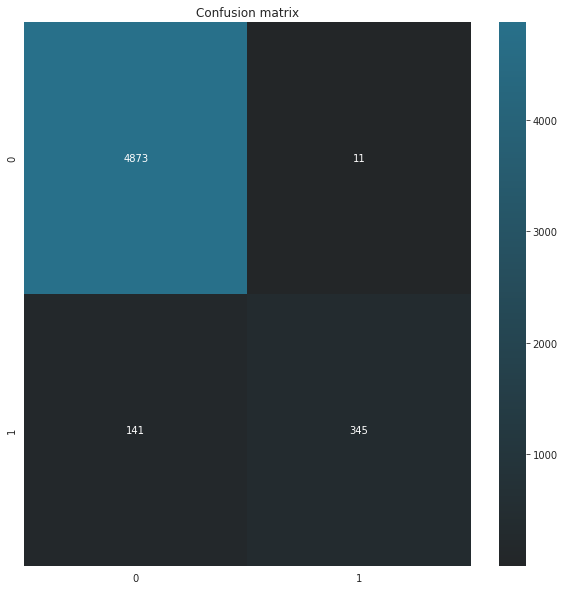

In [66]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
cf_matrix = confusion_matrix(result.samples_tfd.y_test, result.y_test_hat)

figsize = (10,10)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=figsize)
    ax.set_title("Confusion matrix")
    sns.heatmap(
        cf_matrix,
        annot=True,
        fmt="0",
        ax=ax,
        vmin=0.3,
        cmap=sns.dark_palette("#28708a", reverse=False, as_cmap=True),
       # mask=mask,
    )

In [67]:
print(classification_report(result.samples_tfd.y_test, result.y_test_hat))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4884
           1       0.97      0.71      0.82       486

    accuracy                           0.97      5370
   macro avg       0.97      0.85      0.90      5370
weighted avg       0.97      0.97      0.97      5370



In [ ]:
# figsize = (12, 12)
# plot_data = pair_data.fillna(1)
# plt = plot_triangle_accuracies(
#     plot_data, figsize, title="Accuracy for genre pairs, Classical 9 paramaters"
# )
# plt.savefig("classical_best_10_pair.svg")